In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto, norm, beta, cauchy

from GBEX_GPD import GBEX_GPD
from RF_Quantile import RF_Quantile
from Extreme_quantile_regressor import Extreme_quantile_regressor

from Simulation_utils import visualize_extreme_quantile_predictions, visualize_predictions, visualize_quantile_predictions, visualize_quantile_function
from Simulation_utils import get_gaussian_dataset, get_GPD_dataset

## Test of algorithm 1: Gradient boosting for estimation of GPD parameters

### Tests on synthetic datasets with $X \in \mathbb{R}^2$

#### Dataset with constant $\sigma, \gamma$

Generation of a dataset from a GPD with constant parameters (no dependence on the covariates $X$)

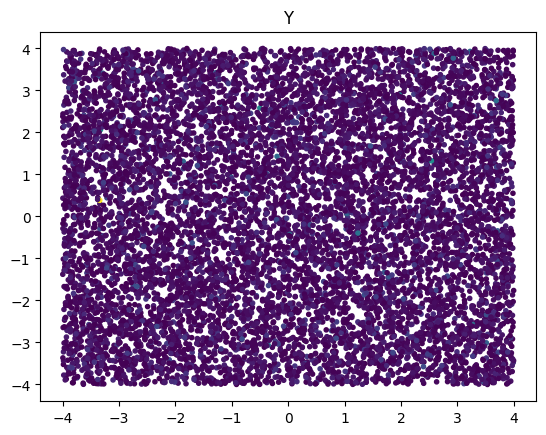

True parameters: sigma=1, gamma=0.1
MLE estimator: sigma=0.9996551655709847, gamma=0.10556226332748571


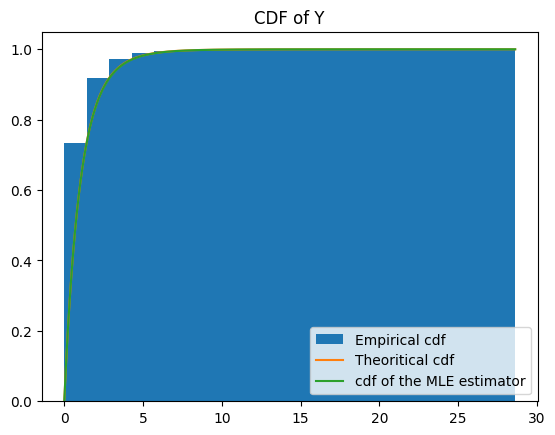

In [2]:
gamma = 1e-1
sigma = 1

# Generate the dataset
X, Y = get_GPD_dataset(10000, gamma_function=lambda x:gamma, 
                              sigma_function=lambda x:sigma)

plt.scatter(X[:, 0], X[:, 1], c=Y, marker=".")
plt.title("Y")
plt.show()

gamma_hat, _, sigma_hat = genpareto.fit(Y, floc=0)
print("True parameters: sigma={}, gamma={}".format(sigma, gamma))
print("MLE estimator: sigma={}, gamma={}".format(sigma_hat, gamma_hat))

xx = np.linspace(min(Y), max(Y), 1000)
plt.hist(Y, cumulative=True, density=True, bins=20, label="Empirical cdf")
plt.plot(xx, 1-(1+gamma*xx/sigma)**(-1/gamma), label="Theoritical cdf")
plt.plot(xx, 1-(1+gamma_hat*xx/sigma_hat)**(-1/gamma_hat), label="cdf of the MLE estimator")
plt.title("CDF of Y")
plt.legend()
plt.show()

Initialization with sigma=0.9996551655709847 and gamma=0.10556226332748571


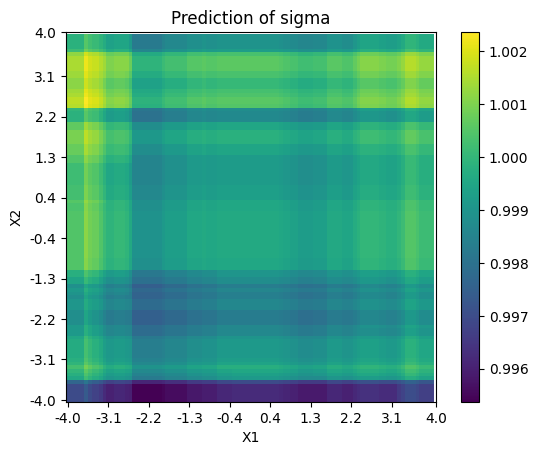

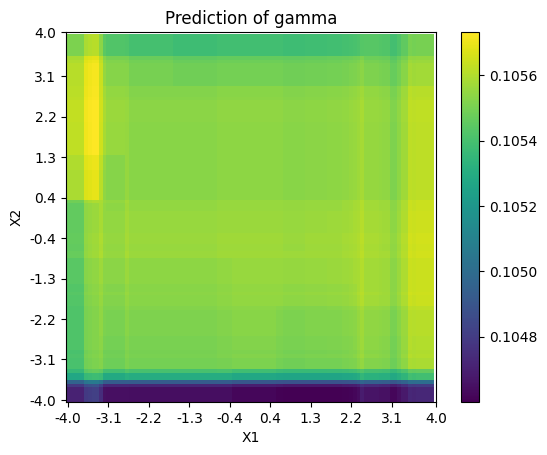

In [3]:
gbex_gpd = GBEX_GPD(lamb_scale=1e-3, B=50, L_sig=int(X.shape[0]/50), L_gam=int(X.shape[0]/50))
gbex_gpd.fit(X, Y)
visualize_predictions(gbex_gpd)

#### Dataset with $\sigma, \gamma$ as functions of X

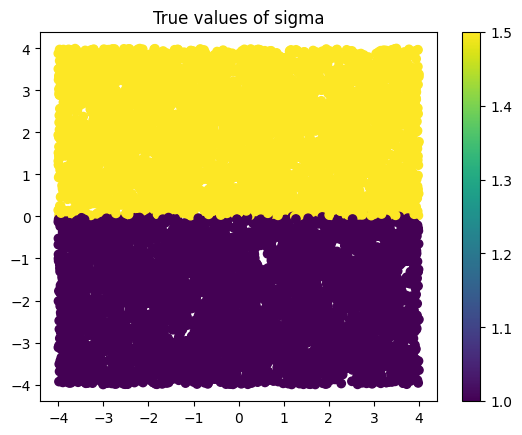

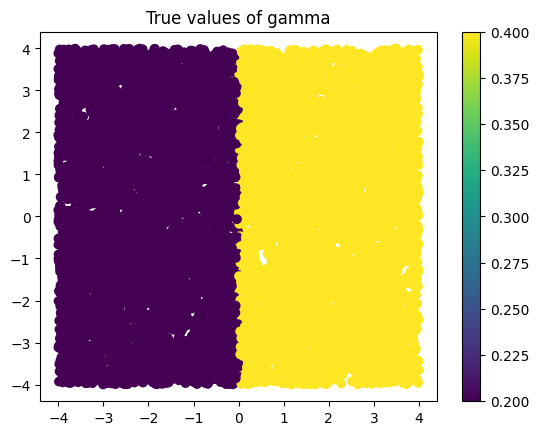

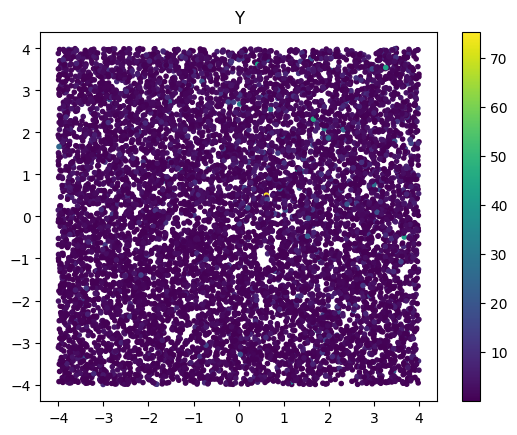

MLE estimator: sigma=1.2329329062195011, gamma=0.3154560570023006


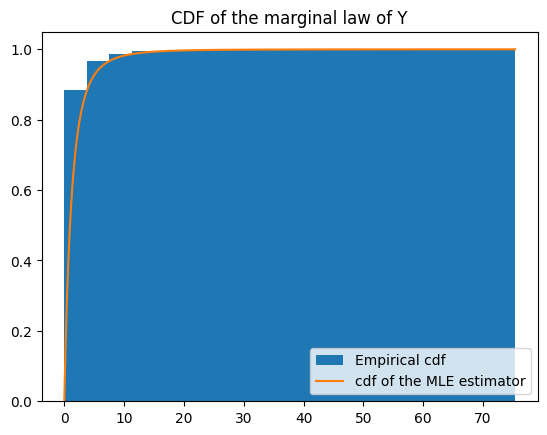

In [9]:
X, Y = get_GPD_dataset(10000, gamma_function=lambda x: 2e-1 if x[0]<0 else 4e-1, 
                              sigma_function=lambda x: 1 if x[1]<0 else 1.5,
                              plot=True)


gamma_hat, _, sigma_hat = genpareto.fit(Y, floc=0)
print("MLE estimator: sigma={}, gamma={}".format(sigma_hat, gamma_hat))

xx = np.linspace(min(Y), max(Y), 1000)
plt.hist(Y, cumulative=True, density=True, bins=20, label="Empirical cdf")
plt.plot(xx, 1-(1+gamma_hat*xx/sigma_hat)**(-1/gamma_hat), label="cdf of the MLE estimator")
plt.title("CDF of the marginal law of Y")
plt.legend()
plt.show()


In [10]:
gbex_gpd = GBEX_GPD(B=200, D_sig=1, D_gam=1, lamb_scale=5e-2, lamb_ratio=2, s=0.5, L_sig=100, L_gam=100)
gbex_gpd.fit(X, Y)

Initialization with sigma=1.2329329062195011 and gamma=0.3154560570023006


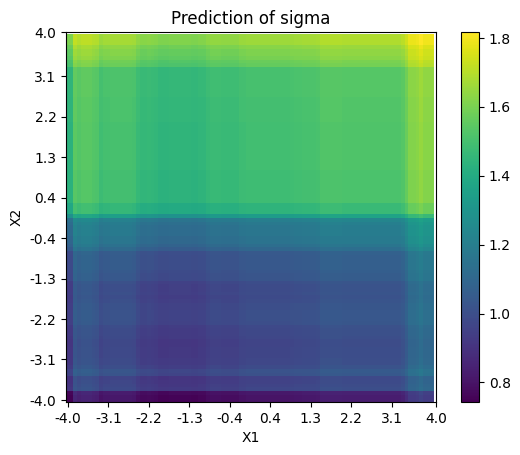

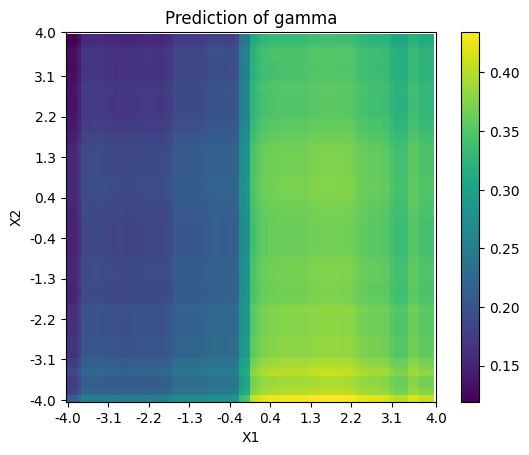

In [11]:
visualize_predictions(gbex_gpd)

## Test of Algorithm 2: full pipeline including thresholding according to the intermediate quantile estimator

#### Test the random forest intermediate quantile estimator on a gaussian dataset

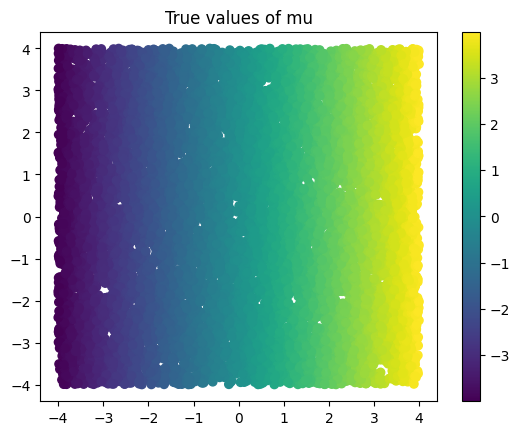

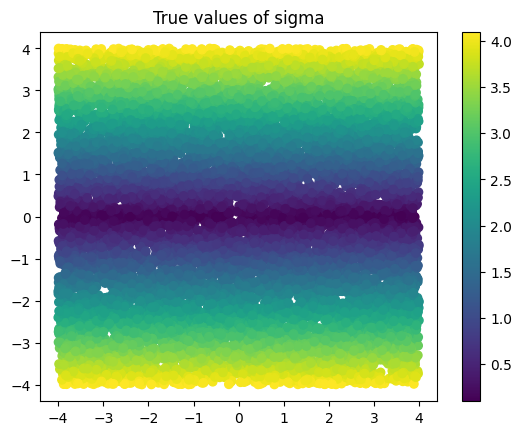

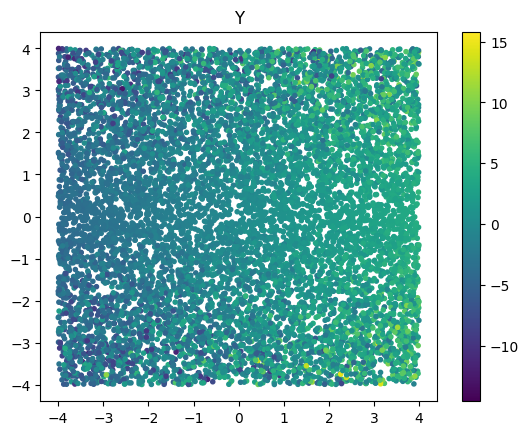

In [9]:
X, Y = get_gaussian_dataset(10000, mu_function=lambda x: x[0], 
                                   sigma_function=lambda x: 0.1 + np.abs(x[1]),
                                   plot=True)

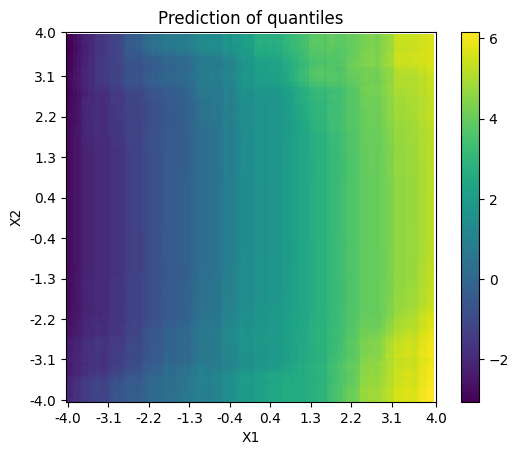

In [10]:
quantile_est = RF_Quantile(0.8, N_trees=100, D_max=5, s=0.1)
quantile_est.fit(X, Y)
visualize_quantile_predictions(quantile_est)

#### Test the whole pipeline of algorithm 2

Test on a dataset generated by a GPD with piecewise constant parameters

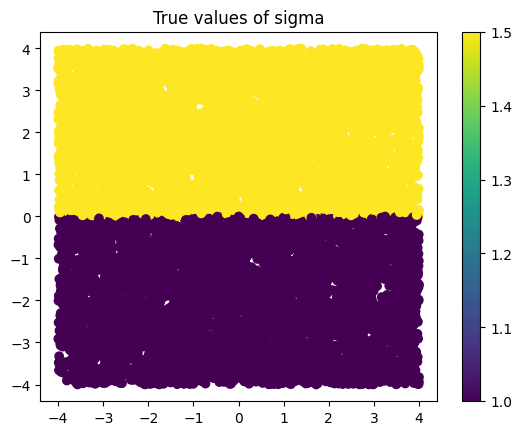

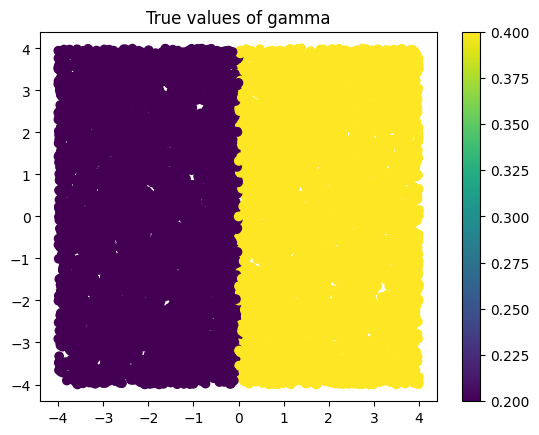

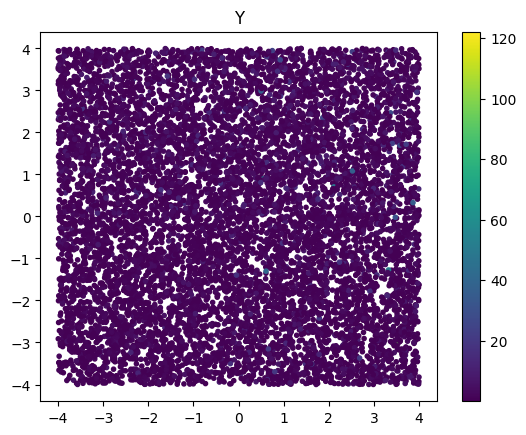

Initialization with sigma=2.200054963127897 and gamma=0.3372121928898149


In [11]:
X, Y = get_GPD_dataset(10000, gamma_function=lambda x: 2e-1 if x[0]<0 else 4e-1, 
                              sigma_function=lambda x: 1 if x[1]<0 else 1.5,
                              plot=True)

ex_quant_reg = Extreme_quantile_regressor(0.9, B=100, D_sig=2, D_gam=2, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)

Prediction of the intermediate quantiles

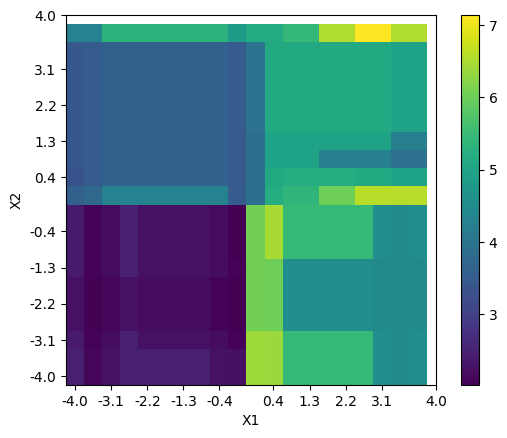

In [12]:
visualize_quantile_function(lambda x: ex_quant_reg.intermediate_Q_est.predict([x], 0.9), n_pts_x1=20, n_pts_x2=20)

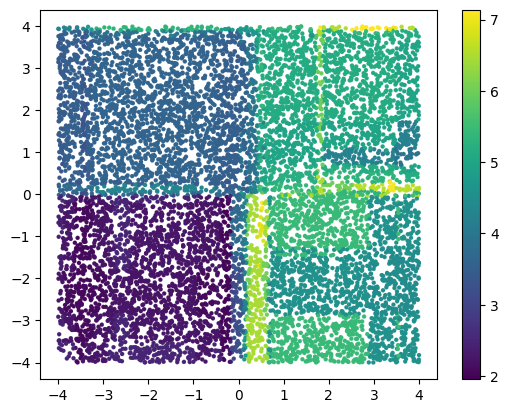

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=ex_quant_reg.intermediate_Q_est.predict(X, 0.9), marker='.', linewidths=0.1)
plt.colorbar()
plt.show()

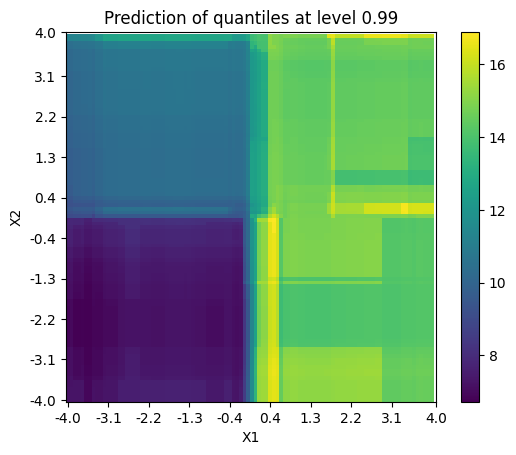

In [14]:
visualize_extreme_quantile_predictions(ex_quant_reg, 0.99)

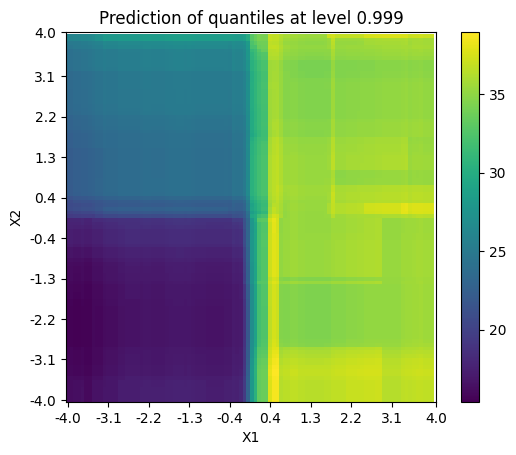

In [15]:
visualize_extreme_quantile_predictions(ex_quant_reg, 0.999)

#### Test on a dataset generated from a gaussian distribution with continuously varying parameters

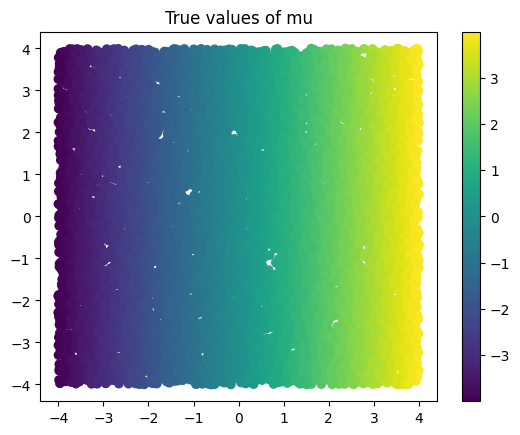

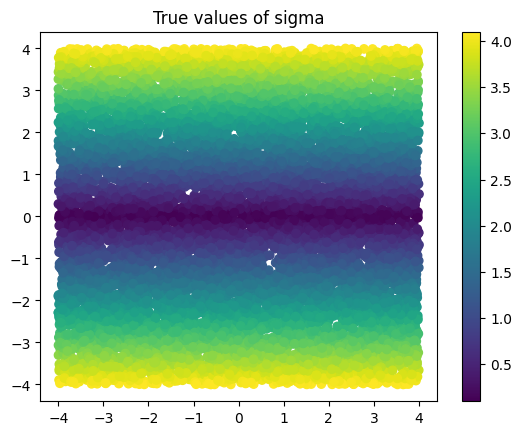

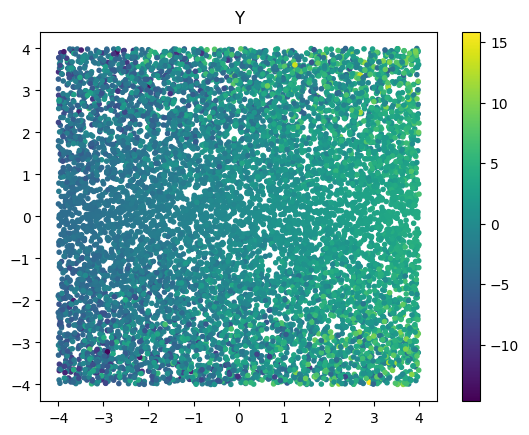

Initialization with sigma=1.9257768970391886 and gamma=-0.1330901653696839


In [17]:
tau = 0.999
mu_function=lambda x: x[0]
sigma_function=lambda x: 0.1 + np.abs(x[1])


X, Y = get_gaussian_dataset(10000, mu_function=mu_function, sigma_function=sigma_function, plot=True)

ex_quant_reg = Extreme_quantile_regressor(0.9, B=100, D_sig=0, D_gam=0, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)

True quantile function

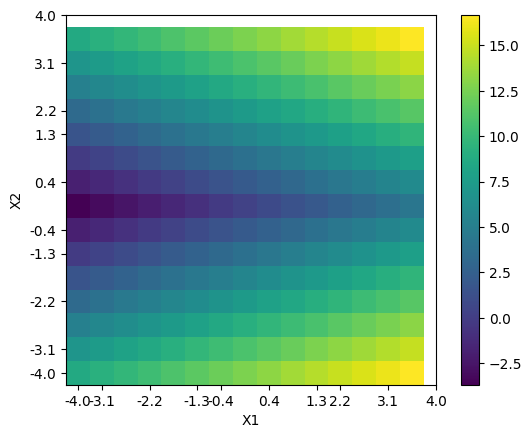

In [18]:
visualize_quantile_function(lambda x: norm.ppf(0.999, loc=mu_function(x), scale=sigma_function(x)), n_pts_x1=15, n_pts_x2=15)

## Different domain of attraction

Test the performances of the algorithm on distribution from the three domains of attraction of extreme values theory

### Fréchet domain: Cauchy distribution ($\gamma=1$) 

Initialization with sigma=2.829051330826519 and gamma=1.0086724391522055


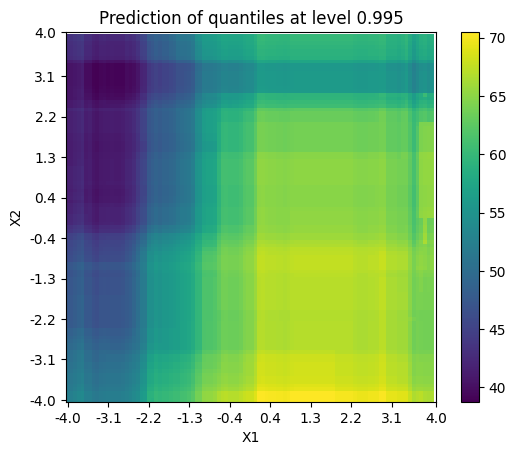

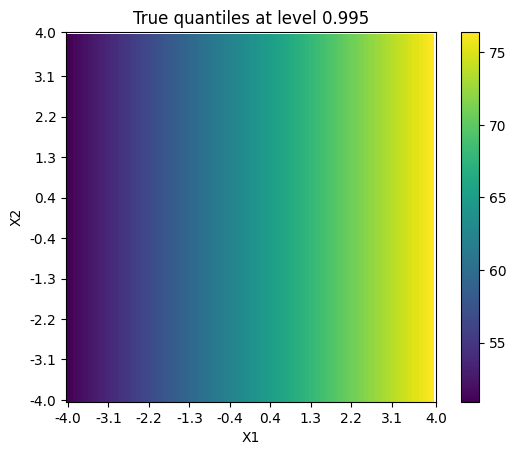

In [2]:
dim = 2
N = 10000

np.random.seed(0)

X = (np.random.random((N, 2))-0.5)*8
Y = np.zeros(N)

scale = lambda x: 1 + 0.05*x[0]
for i in range(N):
    Y[i] = np.random.standard_cauchy()*scale(X[i])

ex_quant_reg = Extreme_quantile_regressor(0.9, B=100, D_sig=2, D_gam=1, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)
tau = 0.995
visualize_extreme_quantile_predictions(ex_quant_reg, tau)
visualize_quantile_function(lambda x: cauchy.ppf(tau, loc=0, scale=scale(x)), title="True quantiles at level " + str(tau))

### Gumbel domain: Exponential distribution ($\gamma = 0$)

Initialization with sigma=0.9763327753679962 and gamma=0.04845195520977421


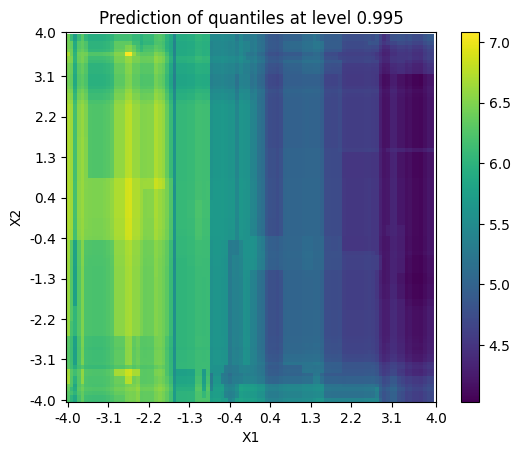

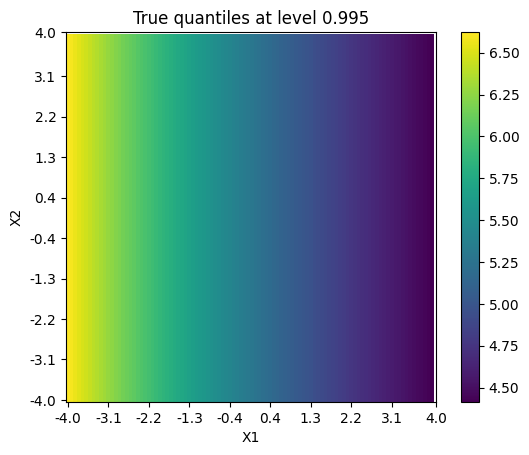

In [3]:
dim = 2
N = 10000

np.random.seed(111111)

X = (np.random.random((N, 2))-0.5)*8
Y = np.zeros(N)

lamb = lambda x: 1 + 0.05*x[0]
for i in range(N):
    Y[i] = np.random.exponential(1/lamb(X[i]))

ex_quant_reg = Extreme_quantile_regressor(0.9, B=100, D_sig=2, D_gam=1, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)
tau = 0.995
visualize_extreme_quantile_predictions(ex_quant_reg, tau)
visualize_quantile_function(lambda x: -np.log(1-tau)/lamb(x), title="True quantiles at level " + str(tau))

### Weibull domain: Beta distribution with $\beta > 0$, ($\gamma = -\frac{1}{\beta}$)

Initialization with sigma=0.14002813415081267 and gamma=-0.348491588631919


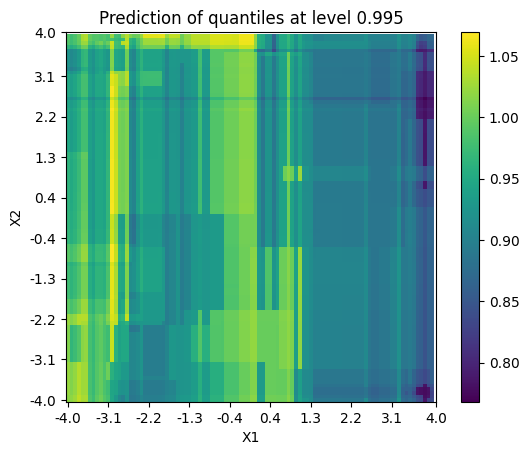

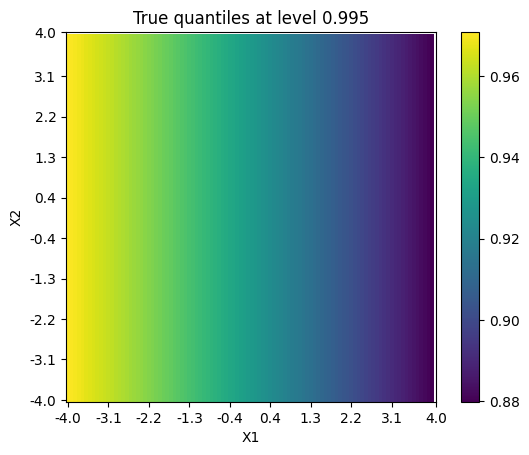

In [7]:
dim = 2
N = 10000

np.random.seed(111111)

X = (np.random.random((N, 2))-0.5)*8
Y = np.zeros(N)

beta_function = lambda x: 2 + x[0]/8
for i in range(N):
    Y[i] = np.random.beta(1, beta_function(X[i]))

ex_quant_reg = Extreme_quantile_regressor(0.9, B=100, D_sig=2, D_gam=1, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)
tau = 0.995
visualize_extreme_quantile_predictions(ex_quant_reg, tau)
visualize_quantile_function(lambda x: beta.ppf(tau, 1, beta_function(x)), title="True quantiles at level " + str(tau))

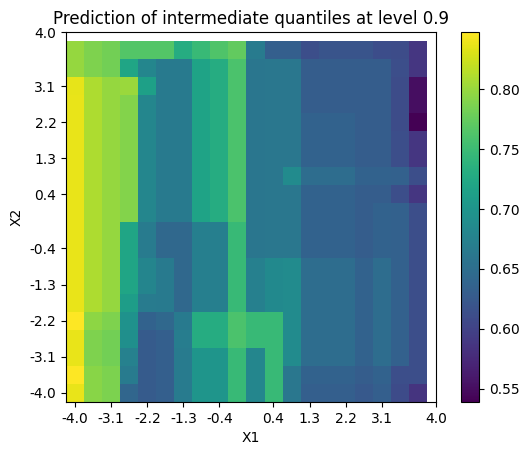

In [8]:
visualize_quantile_function(lambda x: ex_quant_reg.intermediate_Q_est.predict([x], 0.9), n_pts_x1=20, n_pts_x2=20,
                            title="Prediction of intermediate quantiles at level 0.9")

## Dependence in $X$

Experiments on the type of dependence in $X$ of the parameters of the distribution of $Y$.

### Split direction for uniform regions

#### Simple split along one axis

Initialization with sigma=0.7058164033672598 and gamma=0.1445471330125781


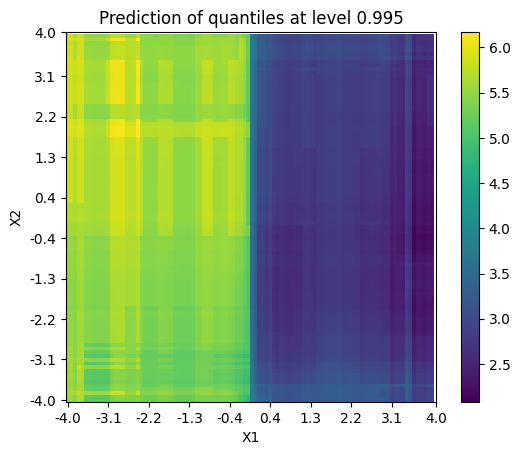

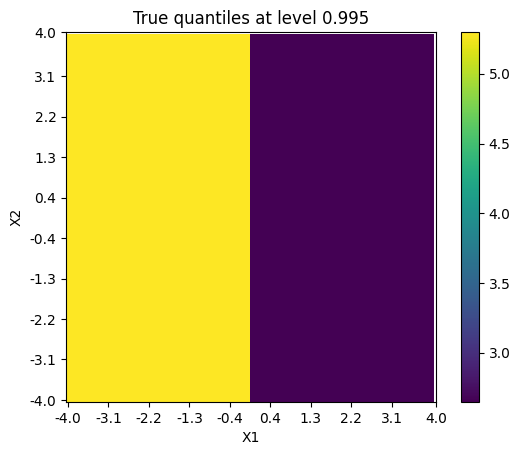

In [5]:
dim = 2
N = 10000

np.random.seed(111111)

X = (np.random.random((N, 2))-0.5)*8
Y = np.zeros(N)

lamb = lambda x: 1 if x[0] < 0 else 2
for i in range(N):
    Y[i] = np.random.exponential(1/lamb(X[i]))

ex_quant_reg = Extreme_quantile_regressor(0.9, B=200, D_sig=2, D_gam=1, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)
tau = 0.995
visualize_extreme_quantile_predictions(ex_quant_reg, tau)
visualize_quantile_function(lambda x: -np.log(1-tau)/lamb(x), title="True quantiles at level " + str(tau))

#### 4-region split along the axis

Initialization with sigma=0.7956277200149202 and gamma=0.09606505775552457


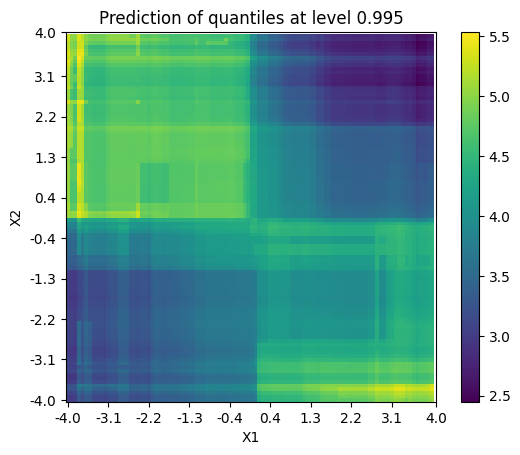

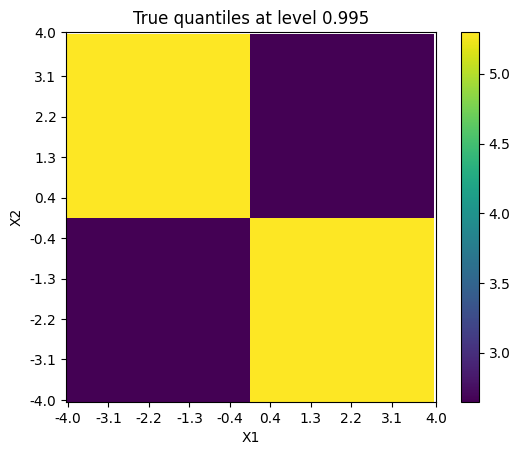

In [6]:
dim = 2
N = 10000

np.random.seed(111111)

X = (np.random.random((N, 2))-0.5)*8
Y = np.zeros(N)

lamb = lambda x: 1 if x[0]*x[1] < 0 else 2
for i in range(N):
    Y[i] = np.random.exponential(1/lamb(X[i]))

ex_quant_reg = Extreme_quantile_regressor(0.9, B=200, D_sig=2, D_gam=1, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)
tau = 0.995
visualize_extreme_quantile_predictions(ex_quant_reg, tau)
visualize_quantile_function(lambda x: -np.log(1-tau)/lamb(x), title="True quantiles at level " + str(tau))

#### Simple diagonal split 

Initialization with sigma=0.7271218544662186 and gamma=0.09839848755415247


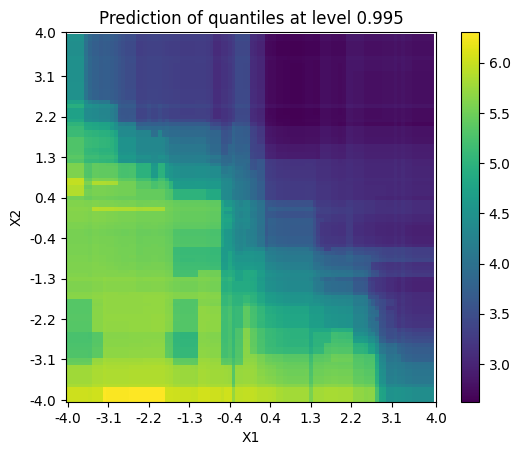

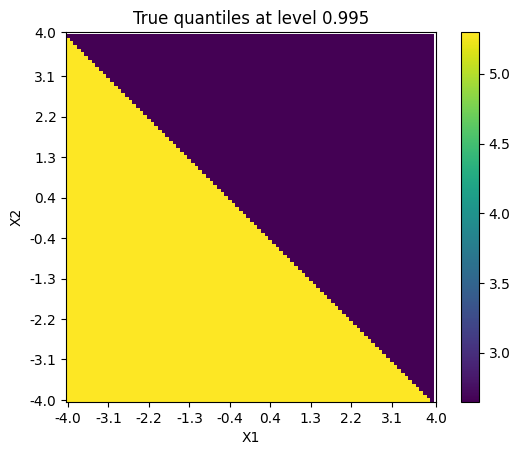

In [7]:
dim = 2
N = 10000

np.random.seed(111111)

X = (np.random.random((N, 2))-0.5)*8
Y = np.zeros(N)

lamb = lambda x: 1 if x[0] + x[1] < 0 else 2
for i in range(N):
    Y[i] = np.random.exponential(1/lamb(X[i]))

ex_quant_reg = Extreme_quantile_regressor(0.9, B=100, D_sig=2, D_gam=1, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)
tau = 0.995
visualize_extreme_quantile_predictions(ex_quant_reg, tau)
visualize_quantile_function(lambda x: -np.log(1-tau)/lamb(x), title="True quantiles at level " + str(tau))

#### 4-region diagonal split

Initialization with sigma=0.7832399854589048 and gamma=0.12479118252551559


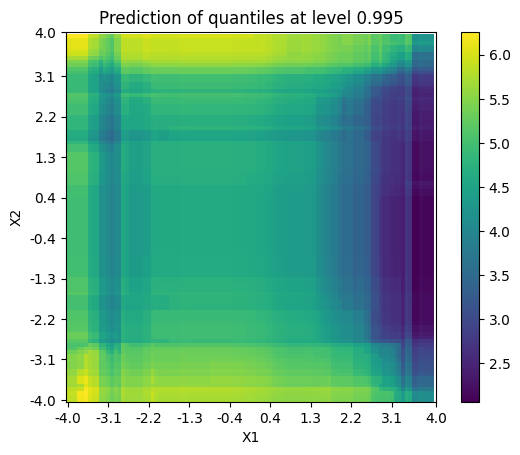

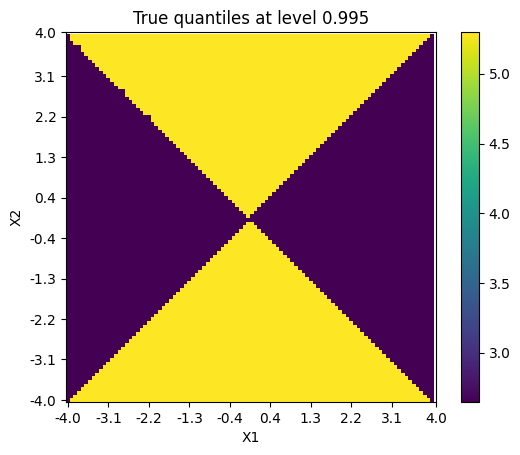

In [5]:
dim = 2
N = 10000

np.random.seed(111111)

X = (np.random.random((N, 2))-0.5)*8
Y = np.zeros(N)

lamb = lambda x: 1 if (x[0] + x[1])*(x[0] - x[1]) < 0 else 2
for i in range(N):
    Y[i] = np.random.exponential(1/lamb(X[i]))

ex_quant_reg = Extreme_quantile_regressor(0.9, B=100, D_sig=2, D_gam=1, lamb_scale=0.02, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)
tau = 0.995
visualize_extreme_quantile_predictions(ex_quant_reg, tau)
visualize_quantile_function(lambda x: -np.log(1-tau)/lamb(x), title="True quantiles at level " + str(tau))

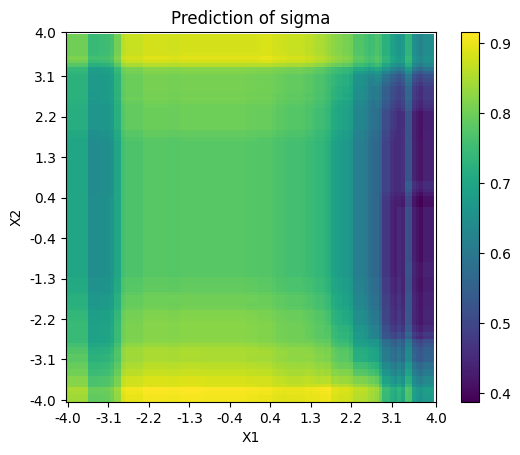

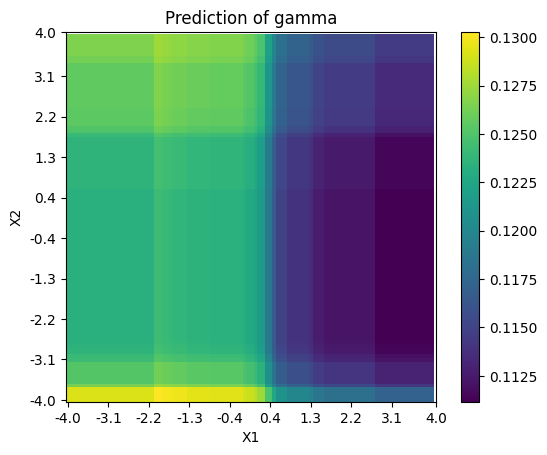

In [26]:
visualize_predictions(ex_quant_reg.GPD_est)

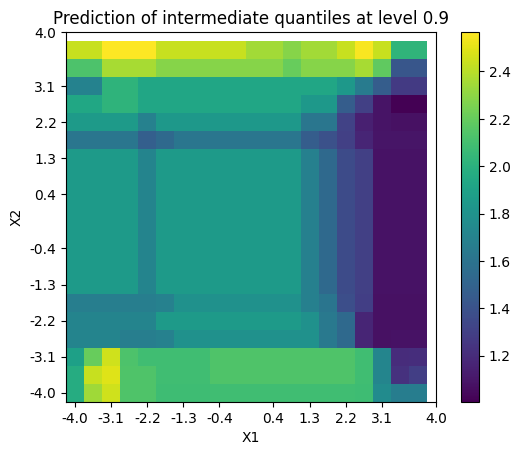

In [6]:
visualize_quantile_function(lambda x: ex_quant_reg.intermediate_Q_est.predict([x], 0.9), n_pts_x1=20, n_pts_x2=20,
                            title="Prediction of intermediate quantiles at level 0.9")

### Ramp parameter

#### Along axis

Initialization with sigma=1.0149755018601687 and gamma=0.038903527337391566


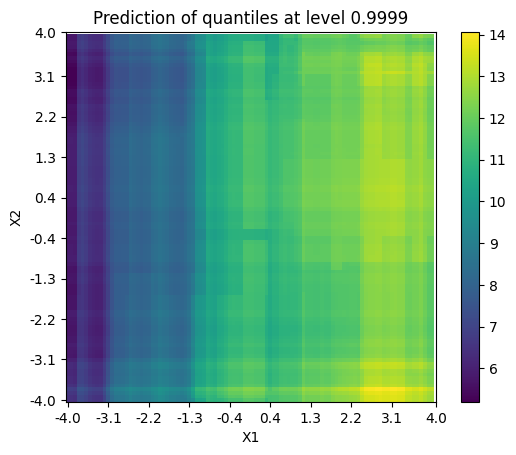

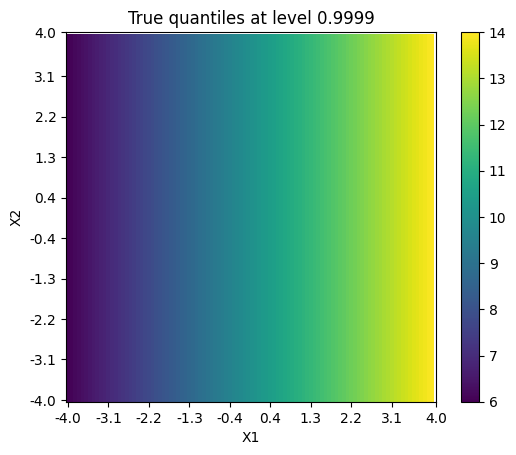

In [28]:
dim = 2
N = 10000

np.random.seed(111111)

X = (np.random.random((N, 2))-0.5)*8
Y = np.zeros(N)
tau = 0.9999

lamb = lambda x: -np.log(1-tau) / (10 + x[0])
for i in range(N):
    Y[i] = np.random.exponential(1/lamb(X[i]))

ex_quant_reg = Extreme_quantile_regressor(0.9, B=200, D_sig=2, D_gam=1, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)
visualize_extreme_quantile_predictions(ex_quant_reg, tau)
visualize_quantile_function(lambda x: -np.log(1-tau)/lamb(x), title="True quantiles at level " + str(tau))

#### Other direction

Initialization with sigma=1.070040843898374 and gamma=0.05010749779386199


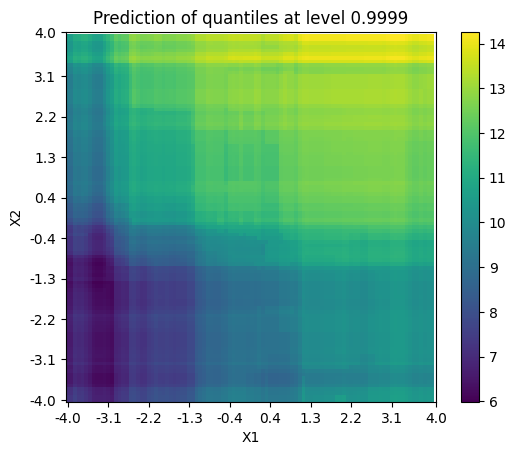

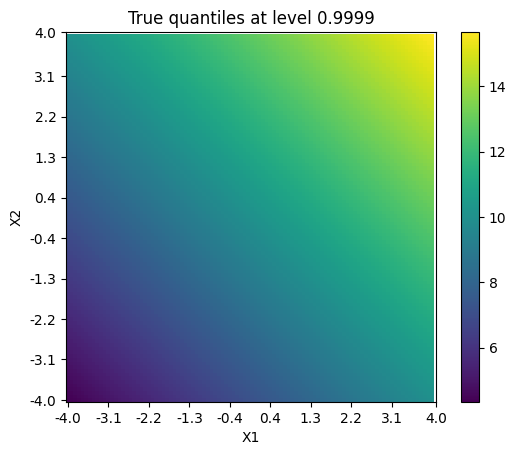

In [29]:
dim = 2
N = 10000

np.random.seed(111111)

X = (np.random.random((N, 2))-0.5)*8
Y = np.zeros(N)
tau = 0.9999

lamb = lambda x: -np.log(1-tau) / (10 + (x[0] + x[1])/np.sqrt(2))
for i in range(N):
    Y[i] = np.random.exponential(1/lamb(X[i]))

ex_quant_reg = Extreme_quantile_regressor(0.9, B=200, D_sig=2, D_gam=1, lamb_scale=0.01, lamb_ratio=10, s=0.5, L_sig=10, L_gam=10)
ex_quant_reg.fit(X, Y)
visualize_extreme_quantile_predictions(ex_quant_reg, tau)
visualize_quantile_function(lambda x: -np.log(1-tau)/lamb(x), title="True quantiles at level " + str(tau))